# Milestone 2

### Recap: Statement of Problem

A restauranteur is planning to open a new restaurant specializing in vegan cuisine and would like to predict the success of new recipes created by the restaurant's chefs before they are served to the public. The restauranteur has hired a team of data scientists to develop a model to predict the success of new recipes based on ratings and reviews of existing recipes. The data scientists have obtained a data set from food.com (via kaggle.com) with recipes that have been rated and reviewed by the site's users. They now must determine the feasibility of developing a working model to predict the rating of a given recipe based on other attributes supplied in the data set. The initial goal is to develop a model that can predict a recipe's rating based attributes such as nutritional content, ingredients, visual characteristics, and a range of descriptive tags of recipes. A longer range goal is to perform sentiment analysis on the reviews. When the model is developed, the restaurant's chefs hope to be able to tweak the recipes they create to achieve higher ratings with the restaurant's guests and visiting food critics.

### Preparation

Import required libraries:

In [47]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import sys

from sklearn.preprocessing import scale
from scipy.stats import kstest

Define global options:

In [48]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Display full array
np.set_printoptions(threshold=sys.maxsize)

Declare functions:

In [30]:
# The following functions are from DataScience410/Lecture4/HypothesisTesting_Distributions.ipynb

# Perform a Q-Q plot
def qq_plot(vec1, vec2):
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

# Perform a cumulative distribution plot
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')

# Perform a Kolmogorov-Smirnov Test
def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

### Load the Data Set

Original source of the data set is https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions/version/2.

I have extracted vegan recipes from the original data set and cleaned the data in various ways as part of my milestone project for DATASCI 400 CS as well as the present milestone project:
- Removed recipes that are not vegan based on a string-based list of tags in the kaggle.com data set
- Removed recipes that contain non-vegan ingredients that were mis-tagged as vegan in the kaggle.com data set (e.g. chicken, eggs, dairy products, etc.)
- Removed desserts, breads, and other recipes that are not main courses, sides, soups, salads, and appetizer
- Removed recipes that are incomplete for serving in a restaurant, such as spice rubs, marinades
- Removed recipes with incomplete nutritional data
- Removed recipes with an insufficient number of user reviews (less than three)
- Added missing variables that are listed on the web site but not in the data set, for example, serving size and number of servings. These variables are crucial to make use of the nutritional information for comparisons but are missing in the kaggle.com data set. I have re-added these fields to the data set by scraping food.com web side and parsing the HTML for the proper fields.
- Created dichotomous variables for categorical data parsed from string-based lists in the kaggle.com data set

The new data set is https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data

In [9]:
# Internet location of the data set
url = 'https://raw.githubusercontent.com/pelorenz/vegan_recipes/master/vegan_recipes_v2.data'

# Download the data into a dataframe object
recipes = pd.read_table(url)

### Summary Statistics

An overview of summary statistics for numeric attributes:

In [10]:
pd.options.display.float_format = '{:.4f}'.format
recipes[['n_ingredients', 'serving_size_g', 'n_servings', 'calories', 'calories_per_g', 
         'total_fat_pdv', 'total_fat_g', 'total_fat_pct', 'sugar_pdv', 'sugar_g', 
         'sugar_pct', 'sodium_pdv', 'sodium_g', 'sodium_pct', 'protein_pdv', 'protein_g', 
         'protein_pct', 'saturated_fat_pdv', 'saturated_fat_g', 'saturated_fat_pct', 
         'carbohydrates_pdv', 'carbohydrates_g', 'carbohydrates_pct', 'num_reviews', 
         'mean_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_ingredients,2968.0000,9.2426,3.7581,2.0000,7.0000,9.0000,12.0000,25.0000
serving_size_g,2968.0000,347.8851,806.7239,2.0000,124.0000,202.0000,326.2500,19215.0000
n_servings,2968.0000,5.0313,5.7899,1.0000,4.0000,4.0000,6.0000,192.0000
calories,2968.0000,263.9339,290.5454,0.1000,111.8000,195.6000,315.1000,4055.1000
calories_per_g,2968.0000,1.3029,1.3942,0.0009,0.5716,0.9560,1.5477,26.1984
total_fat_pdv,2968.0000,16.9869,35.0557,0.0000,3.0000,9.0000,20.0000,704.0000
total_fat_g,2968.0000,11.0415,22.7862,0.0000,1.9500,5.8500,13.0000,457.6000
total_fat_pct,2968.0000,0.0633,0.1336,0.0000,0.0078,0.0285,0.0679,2.8238
sugar_pdv,2968.0000,35.9693,101.5755,0.0000,7.0000,16.0000,33.0000,3162.0000
sugar_g,2968.0000,17.9847,50.7877,0.0000,3.5000,8.0000,16.5000,1581.0000


TODO: classical, bootstrap, and Bayesian methods, including for individual tests: Statistical analysis performed appropriately for each of the different methods.

TODO: explore the dataset supported by charts and summary statistics throughout

### Identify Distributions

We begin by identifying a likely distribution for several of the features.

#### Testing the Distribution of *mean_rating* and log(*mean_rating*)

First, perform normality tests via graphical methods using a Q-Q plot and a comparison plot of cumulative distribution functions on price and log(price). Then perform a formal Kolmogorov-Smirnov Test.

##### Graphical Method 1: Q-Q Plot

The Q-Q plot of *mean_rating*:

array([4.5 , 4.75, 3.75, ..., 4.75, 5.  , 5.  ])

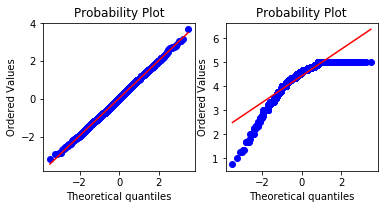

In [24]:
# generate a normal distribution for comparison
nr.seed(1357)
norm1 = nr.normal(size = len(mean_rating)).tolist()

# get 'mean_rating' column as array excluding undefined, zero, and negative values
mean_rating = np.array(recipes['mean_rating'].values)

mean_rating

# perform Q-Q plot of 'mean_rating'
qq_plot(norm1, mean_rating)

Clearly, we don't have a normal distribution for *mean_rating*.

The Q-Q plot of log(*mean_rating*):

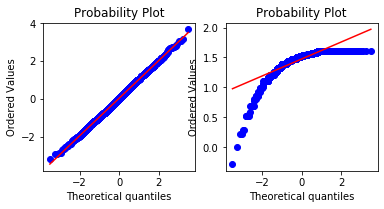

In [22]:
# compute log of 'mean_rating'
log_mean_rating = np.log(mean_rating)

# perform Q-Q plot of 'log_mean_rating'
qq_plot(norm1, log_mean_rating)

The distribution of log(*mean_rating*) is not normal either.

##### Graphical Method 2: Comparison of Cumulative Distribution Functions

Perform a normality test using a comparison plot of cumulative distribution functions on *mean_rating*:

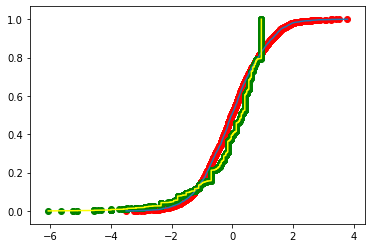

In [27]:
# generate a normal distribution with same length as 'mean_rating' for comparison
norm2 = nr.normal(size = len(mean_rating)).tolist()

# scale arrays
norm2_s = scale(norm2)
mean_rating_s = scale(mean_rating)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, mean_rating_s)

Perform a normality test using a comparison plot of cumulative distribution functions on log(*mean_rating*):

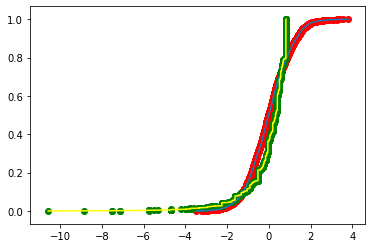

In [33]:
log_mean_rating_s = scale(log_mean_rating)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, log_mean_rating_s)

Neither *mean_rating* nor *log_mean_rating* fits the normal distribution according to comparison of its cumulative distribution function with that of normally-distributed data.

##### Formal Method: Kolmogorov-Smirnov Test

Now perform a formal test of normality, the Kolmogorov-Smirnov test, against *mean_rating*:

In [31]:
ks_test(mean_rating_s)

KS-statistic = 0.1685709267124783
P-value = 1.1091001847399089e-73


The K-S statistic is not small and the p-value is minuscule. The chance that we can safely reject the null hypothesis (the distribution is not normal) is quite low. The distribution is apparently not normal.

Now perform a formal test of normality, the Kolmogorov-Smirnov test, against *log_mean_rating*:

In [34]:
ks_test(log_mean_rating_s)

KS-statistic = 0.2079344443657335
P-value = 6.885581555278203e-112


Again, the K-S statistic is large and the p-value is minuscule, suggesting that the null hypothesis is correct, that the distribution is not normal.

### Hypothesis Testing

We shall test the significance of *mean_rating* by the variables TODO.

#### High-carb, Medium-Carb, Low-Carb

We generate a categorical variable *carb_level* by binning the numeric variable *carbohydrates_pct*, which represents the percent of carbohydrates per recipe by mass relative to the mass of a serving:

In [50]:
# Use percentiles to bin into 3 categories
carb_pct = np.array(recipes['carbohydrates_pct'].values)
low_cutoff = np.percentile(carb_pct, 33)
mid_cutoff = np.percentile(carb_pct, 67)

carb_level = np.array([None] * len(carb_pct))
carb_level[carb_pct <= low_cutoff] = 'low-carb'
carb_level[carb_pct > low_cutoff] = 'medium-carb'
carb_level[carb_pct > mid_cutoff] = 'high-carb'

TODO: Hypothesis testing performed appropriate to the question being addressed.

TODO: compute basic summary statistics by both classical, bootstrap, and Bayesian methods.

TODO: use confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant, i.e. compute confidence intervals for the above summary statistics by classical, bootstrap, and Bayesian methods.

### Conclusion

TODO